In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import Normalize, LogNorm
import os

from hazma.scalar_mediator import ScalarMediator
from hazma.pseudo_scalar_mediator import PseudoScalarMFV
from hazma.vector_mediator import VectorMediator

from hazma.parameters import neutral_pion_mass as mpi0
from hazma.gamma_ray_parameters import (energy_res_fermi, energy_res_e_astrogam,
                                        A_eff_e_astrogam, A_eff_comptel,
                                        egret_diffuse, fermi_diffuse,
                                        comptel_diffuse, gc_target,
                                        gc_bg_model, solid_angle)
from hazma.cmb import vx_cmb

from utilities import latex_text_width_1col
colors = [c["color"] for c in list(plt.rcParams["axes.prop_cycle"])]

## Profiling

In [2]:
# import cProfile

# s_theta = 0.5
# sm_hp = ScalarMediator(mx=1., ms=1000., gsxx=1.0, gsff=s_theta, gsGG=s_theta, gsFF=-s_theta)

# # Masses to scan over
# mx_min, mx_max, n_mxs = mpi0/2., 250., 100  # 100
# sm_mxs = np.linspace(mx_min, mx_max, n_mxs)

In [3]:
# cProfile.run('sm_lims_egret = sm_hp.binned_limits(sm_mxs, egret_diffuse)')

         450442 function calls (450426 primitive calls) in 0.981 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.981    0.981 <string>:1(<module>)
     8114    0.002    0.000    0.002    0.000 __init__.py:152(mx)
        8    0.000    0.000    0.001    0.000 __init__.py:156(mx)
      101    0.000    0.000    0.000    0.000 __init__.py:162(ms)
       38    0.000    0.000    0.000    0.000 __init__.py:172(gsxx)
       63    0.000    0.000    0.000    0.000 __init__.py:182(gsff)
       32    0.000    0.000    0.000    0.000 __init__.py:192(gsGG)
       23    0.000    0.000    0.000    0.000 __init__.py:202(gsFF)
        8    0.000    0.000    0.000    0.000 __init__.py:212(compute_vs)
        8    0.000    0.000    0.001    0.000 __init__.py:232(compute_width_s)
        8    0.000    0.000    0.065    0.008 __init__.py:48(total_spectrum)
        7    0.000    0.000    0.000    0.000 _methods.py

KeyboardInterrupt: 

## Relic density curve

In [4]:
rd_mxs_s_wave, rd_lims_s_wave = np.loadtxt("relic_abundance.dat", delimiter=",").T
rd_mxs_s_wave = 1e3*10.**rd_mxs_s_wave  # convert GeV -> MeV
rd_lims_s_wave = 10.**rd_lims_s_wave

def rd_lim_fn_p_wave(mxs):
    """Computes approximate value of <sigma v>_0 (ie, in the Milky Way) required
    to give the correct relic abundance.
    
    Notes
    -----
    I'm using the logic of arXiv:1703.02546:
    * From arxiv:1308.2578, <sigma v>_fo ~ 6 x 10^-26 cm^3/s.
    * Velocity at freeze out is v_fo = sqrt(3 T_fo / m) ~ 0.4 (using T ~ mx/20).
    * <sigma v>_0 = <sigma v>_fo * (v_0 / v_fo)^2.
    """
    def helper(mx):
        return 6e-26 * (1e-3 / 0.4)**2
    
    return np.vectorize(helper)(mxs)

# Scalar mediator

## Setup

In [5]:
s_theta = 0.5
sm_hp = ScalarMediator(mx=1., ms=1000., gsxx=1.0, gsff=s_theta, gsGG=s_theta, gsFF=-s_theta)

# Masses to scan over
mx_min, mx_max, n_mxs = mpi0/2., 250., 100  # 100
sm_mxs = np.linspace(mx_min, mx_max, n_mxs)

## Recompute constraints

In [3]:
sm_lims_e_astrogam = sm_hp.unbinned_limits(sm_mxs, target_params=gc_target, bg_model=gc_bg_model)

6
6
7
6


/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/gamma_ray_limits/compute_limits.py:44: RuntimeWarning: invalid value encountered in sqrt
  df_de_a = 1./np.sqrt(I_B_val) * \
/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/gamma_ray_limits/compute_limits.py:46: RuntimeWarning: invalid value encountered in sqrt
  df_de_b = -1./np.sqrt(I_B_val) * \
/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/gamma_ray_limits/compute_limits.py:50: RuntimeWarning: invalid value encountered in sqrt
  return -I_S_val/np.sqrt(I_B_val), jac_val


89
78
80
91
48
75
103
88
68
100
92
58
97
78
84
94
66
66
14
15
18
17


/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


15
13
14
14
11
13
12
12
11
11
11
11
33
53
71
54
66
39
62
29
58
59
55
32
46
67
76
69
58
67
55
66
69
67
40
39
35
30
23
22
22
28
37
41
36
35
28
23
59
49
24
24
22
51
24
36
34
35
69
28
71
65
26
32
29
48
66
36
44
45
43
55
55
53
60


In [ ]:
sm_lims_egret = sm_hp.binned_limits(sm_mxs, egret_diffuse)

In [ ]:
sm_lims_egret = sm_hp.binned_limits(sm_mxs, egret_diffuse)
sm_lims_comptel = sm_hp.binned_limits(sm_mxs, comptel_diffuse)
sm_lims_fermi = sm_hp.binned_limits(sm_mxs, fermi_diffuse)

In [ ]:
# sm_lims_cmb = sm_hp.cmb_limits(sm_mxs)

### Save results

In [ ]:
np.savetxt("data/sm_lims_egret.csv",
           np.array([sm_mxs, sm_lims_egret]).T,
           delimiter=",",
           header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")
np.savetxt("data/sm_lims_comptel.csv",
           np.array([sm_mxs, sm_lims_comptel]).T,
           delimiter=",",
           header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")
np.savetxt("data/sm_lims_fermi.csv",
           np.array([sm_mxs, sm_lims_fermi]).T,
           delimiter=",",
           header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

np.savetxt("data/sm_lims_e_astrogam.csv",
           np.array([sm_mxs, sm_lims_e_astrogam]).T,
           delimiter=",",
           header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

# np.savetxt("data/sm_lims_cmb.csv",
#            np.array([sm_mxs, sm_lims_cmb]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

## Load previously computed constraints

In [6]:
sm_mxs, sm_lims_egret = np.loadtxt("data/sm_lims_egret.csv", delimiter=",").T
sm_mxs, sm_lims_comptel = np.loadtxt("data/sm_lims_comptel.csv", delimiter=",").T
sm_mxs, sm_lims_fermi = np.loadtxt("data/sm_lims_fermi.csv", delimiter=",").T
sm_mxs, sm_lims_e_astrogam = np.loadtxt("data/sm_lims_e_astrogam.csv", delimiter=",").T
sm_mxs, sm_lims_cmb = np.loadtxt("data/sm_lims_cmb.csv", delimiter=",").T

## Plot results

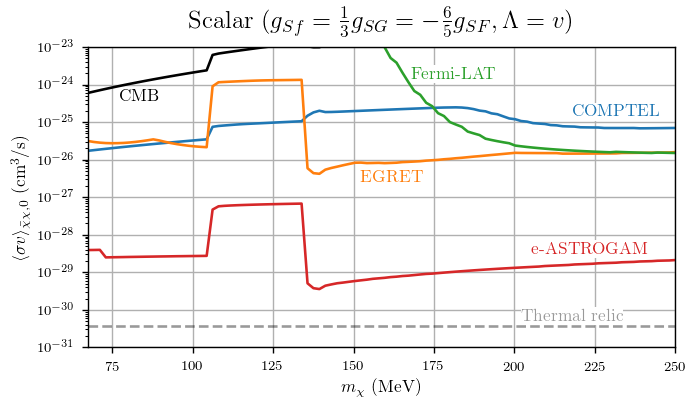

In [8]:
plt.figure(figsize=(latex_text_width_1col,
                    0.6*latex_text_width_1col))

plt.plot(sm_mxs, sm_lims_comptel, label="COMPTEL")
plt.plot(sm_mxs, sm_lims_egret, label="EGRET")
plt.plot(sm_mxs, sm_lims_fermi, label="Fermi")
plt.plot(sm_mxs, sm_lims_e_astrogam, label="e-ASTROGAM")
plt.plot(sm_mxs, (1.0e-3 / vx_cmb(sm_mxs, x_kd=1e-6))**2 * sm_lims_cmb,
         label=r"CMB, $x_{\mathrm{kd}} = 10^{-6}$", color="black")
# plt.plot(sm_mxs, (1.0e-3 / vx_cmb(sm_mxs, x_kd=1e-4))**2 * sm_lims_cmb,
#          label=r"CMB, $x_{\mathrm{kd}} = 10^{-4}$", color="black")
plt.plot(sm_mxs, rd_lim_fn_p_wave(sm_mxs), '--', label="Thermal relic",
         color="black", alpha=0.4)

plt.xlim(sm_mxs[[0, -1]])
plt.ylim([1e-31,1e-23])
plt.yscale("log")
plt.grid()
plt.xlabel(r"$m_\chi$ (MeV)")
plt.ylabel(r"$\langle \sigma v \rangle_{\bar{\chi}\chi,0}$ (cm$^3$/s)")
plt.title(r"Scalar ($g_{Sf} = \frac{1}{3} g_{SG} = -\frac{6}{5} g_{SF}, \Lambda = v$)")

plt.text(218, 1.4e-25, "COMPTEL", fontsize=10, color=colors[0],
         bbox=dict(facecolor='white', edgecolor='none', pad=0.0))
plt.text(152, 2.5e-27, "EGRET", fontsize=10, color=colors[1],
         bbox=dict(facecolor='white', edgecolor='none', pad=0.0))
plt.text(168, 1.4e-24, "Fermi-LAT", fontsize=10, color=colors[2],
         bbox=dict(facecolor='white', edgecolor='none', pad=0.0))
plt.text(205, 3e-29, "e-ASTROGAM", fontsize=10, color=colors[3],
         bbox=dict(facecolor='white', edgecolor='none', pad=0.0))
plt.text(77, 3.5e-25, "CMB", fontsize=10, color='k',
         bbox=dict(facecolor='white', edgecolor='none', pad=0.0))
plt.text(202, 5e-31, "Thermal relic", fontsize=10, color="black", alpha=0.4,
         bbox=dict(facecolor='white', edgecolor='none', pad=0.0))

plt.tight_layout()
plt.savefig("figures/sm_sigmav_limits.pdf")

In [ ]:
import os
os.system('say "Done computing limits"')

# Pseudoscalar mediator

## Setup

Use the benchmark parameters from the 2HDM + pseudoscalar singlet UV completion

In [4]:
s_theta = 0.5
psm = PseudoScalarMFV(mx=200., mp=1e3, gpxx=1.,
                      gpup=1., gpdown=-1., gpll=0.)

# Masses to scan over
mx_min, mx_max, n_mxs = 200., 250., 100  # 100
psm_mxs = np.linspace(mx_min, mx_max, n_mxs)

## Recompute constraints

Start time: 4:35pm

End time: 5:15pm

In [ ]:
psm_lims_e_astrogam = psm.unbinned_limits(psm_mxs, target_params=gc_target, bg_model=gc_bg_model)

In [ ]:
# np.savetxt("data/psm_lims_e_astrogam.csv",
#            np.array([psm_mxs, psm_lims_e_astrogam]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

In [ ]:
os.system("say 'Done with astrogam'")

In [ ]:
psm_lims_egret = psm.binned_limits(psm_mxs, egret_diffuse)

In [ ]:
# np.savetxt("data/psm_lims_egret.csv",
#            np.array([psm_mxs, psm_lims_egret]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

In [ ]:
os.system("say 'Done with EGRET'")

In [ ]:
psm_lims_comptel = psm.binned_limits(psm_mxs, comptel_diffuse)

In [ ]:
# np.savetxt("data/psm_lims_comptel.csv",
#            np.array([psm_mxs, psm_lims_comptel]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

In [ ]:
os.system("say 'Done with comptel'")

In [ ]:
psm_lims_fermi = psm.binned_limits(psm_mxs, fermi_diffuse)

In [ ]:
# np.savetxt("data/psm_lims_fermi.csv",
#            np.array([psm_mxs, psm_lims_fermi]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

In [ ]:
os.system("say 'Done with fermi'")

In [ ]:
psm_lims_cmb = psm.cmb_limits(psm_mxs)

In [ ]:
# np.savetxt("data/psm_lims_cmb.csv",
#            np.array([psm_mxs, psm_lims_cmb]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

In [ ]:
os.system("say 'Done with CMB'")

## Load previously computed constraints

In [57]:
psm_mxs, psm_lims_egret = np.loadtxt("data/psm_lims_egret.csv", delimiter=",").T
psm_mxs, psm_lims_comptel = np.loadtxt("data/psm_lims_comptel.csv", delimiter=",").T
psm_mxs, psm_lims_fermi = np.loadtxt("data/psm_lims_fermi.csv", delimiter=",").T
psm_mxs, psm_lims_e_astrogam = np.loadtxt("data/psm_lims_e_astrogam.csv", delimiter=",").T
psm_mxs, psm_lims_cmb = np.loadtxt("data/psm_lims_cmb.csv", delimiter=",").T

## Plot results

* Fermi limits are weaker since the gamma ray line is the only spectral feature in its lowest-energy bin ($[153, 276]$ MeV), and Br$(\bar{\chi}\chi \to \gamma\gamma)$ decreases as $m_\chi$ increases.
* Feature at 205 MeV comes from the window switching from including the $3\pi$ and $\gamma\gamma$ peaks to just including the $3\pi$ peak. Could certainly get a better limit by using two energy windows: our analysis is conservative/simplistic!

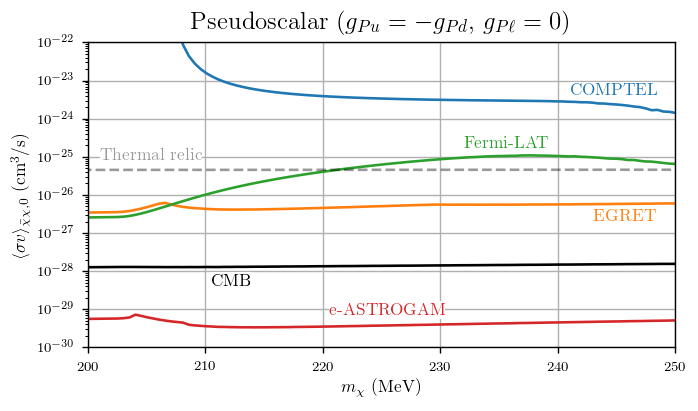

In [68]:
plt.figure(figsize=(latex_text_width_1col,
                    0.6*latex_text_width_1col))

plt.plot(psm_mxs, psm_lims_comptel, label="COMPTEL")
plt.plot(psm_mxs, psm_lims_egret, label="EGRET")
plt.plot(psm_mxs, psm_lims_fermi, label="Fermi")
plt.plot(psm_mxs, psm_lims_e_astrogam, label="e-ASTROGAM")
plt.plot(psm_mxs, psm_lims_cmb, label=r"CMB", color="black")
plt.plot(rd_mxs_s_wave, rd_lims_s_wave, '--', label="Thermal relic",
         color="black", alpha=0.4)

plt.xlim(psm_mxs[[0, -1]])
plt.ylim([1e-30, 1e-22])
# plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.xlabel(r"$m_\chi$ (MeV)")
plt.ylabel(r"$\langle \sigma v \rangle_{\bar{\chi}\chi,0}$ (cm$^3$/s)")  #  * (v_\chi / v_0)^2
plt.title("Pseudoscalar ($g_{Pu} = -g_{Pd}$, $g_{P\ell} = 0$)")

plt.text(241, 4e-24, "COMPTEL", fontsize=10, color=colors[0],
         bbox=dict(facecolor='white', edgecolor='none', pad=0.0))
plt.text(243, 2e-27, "EGRET", fontsize=10, color=colors[1],
         bbox=dict(facecolor='white', edgecolor='none', pad=0.0))
plt.text(232, 1.6e-25, "Fermi-LAT", fontsize=10, color=colors[2],
         bbox=dict(facecolor='white', edgecolor='none', pad=0.0))
plt.text(220.5, 7e-30, "e-ASTROGAM", fontsize=10, color=colors[3],
         bbox=dict(facecolor='white', edgecolor='none', pad=0.0))
plt.text(210.5, 4e-29, "CMB", fontsize=10, color='k',
         bbox=dict(facecolor='white', edgecolor='none', pad=0.0))
plt.text(201, 8e-26, "Thermal relic", fontsize=10, color="black", alpha=0.4,
         bbox=dict(facecolor='white', edgecolor='none', pad=0.0))

plt.tight_layout()
plt.savefig("figures/psm_type_III_2HDM_sigmav_limits.pdf")

In [21]:
import os
os.system('say "Done computing limits"')

0

# Vector mediator

## Setup

In [43]:
vm = VectorMediator(mx=1., mv=1000., gvxx=1., gvuu=1., gvdd=0.2, gvss=0.,
                    gvee=0., gvmumu=0.)

# Masses to scan over
mx_min, mx_max, n_mxs = mpi0/2., 250., 100
vm_mxs = np.linspace(mx_min, mx_max, n_mxs)

## Recompute constraints

In [9]:
vm_lims_comptel = vm.binned_limits(vm_mxs, comptel_diffuse)
vm_lims_egret = vm.binned_limits(vm_mxs, egret_diffuse)
vm_lims_fermi = vm.binned_limits(vm_mxs, fermi_diffuse)

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


In [10]:
vm_lims_e_astrogam = vm.unbinned_limits(vm_mxs, target_params=gc_target, bg_model=gc_bg_model)

/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/gamma_ray_limits/compute_limits.py:146: RuntimeWarning: divide by zero encountered in double_scalars
  lim = prefactor * n_sigma / (-limit_obj.fun)


In [ ]:
# vm_lims_cmb = vm.cmb_limits(vm_mxs)

In [ ]:
# np.savetxt("data/vm_lims_comptel.csv",
#            np.array([vm_mxs, vm_lims_comptel]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")
# np.savetxt("data/vm_lims_egret.csv",
#            np.array([vm_mxs, vm_lims_egret]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")
# np.savetxt("data/vm_lims_fermi.csv",
#            np.array([vm_mxs, vm_lims_fermi]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")
# np.savetxt("data/vm_lims_e_astrogam.csv",
#            np.array([vm_mxs, vm_lims_e_astrogam]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

# np.savetxt("data/vm_lims_cmb.csv",
#            np.array([vm_mxs, vm_lims_cmb]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

## Load previously computed constraints

In [41]:
vm_mxs, vm_lims_egret = np.loadtxt("data/vm_lims_egret.csv", delimiter=",").T
vm_mxs, vm_lims_comptel = np.loadtxt("data/vm_lims_comptel.csv", delimiter=",").T
vm_mxs, vm_lims_fermi = np.loadtxt("data/vm_lims_fermi.csv", delimiter=",").T
vm_mxs, vm_lims_e_astrogam = np.loadtxt("data/vm_lims_e_astrogam.csv", delimiter=",").T
vm_mxs, vm_lims_cmb = np.loadtxt("data/vm_lims_cmb.csv", delimiter=",").T

## Plot results

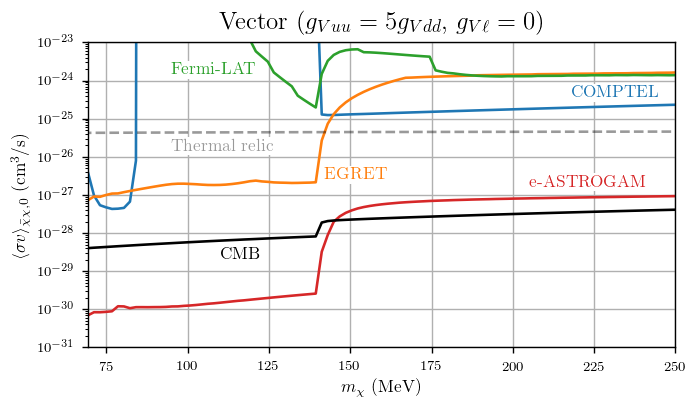

In [55]:
plt.figure(figsize=(latex_text_width_1col,
                    0.6*latex_text_width_1col))

plt.plot(vm_mxs, vm_lims_comptel, label="COMPTEL")
plt.plot(vm_mxs, vm_lims_egret, label="EGRET")
plt.plot(vm_mxs, vm_lims_fermi, label="Fermi")
plt.plot(vm_mxs, vm_lims_e_astrogam, label="e-ASTROGAM")
plt.plot(vm_mxs, vm_lims_cmb, label="CMB", color="black")
plt.plot(rd_mxs_s_wave, rd_lims_s_wave, '--', label="Thermal relic",
         color="black", alpha=0.4)

plt.xlim(vm_mxs[[1, -1]])
plt.ylim([1e-31, 1e-23])
plt.xscale("linear")
plt.yscale("log")
plt.grid()
plt.xlabel(r"$m_\chi$ (MeV)")
plt.ylabel(r"$\langle \sigma v \rangle_{\bar{\chi}\chi,0}$ (cm$^3$/s)")
plt.title(r"Vector ($g_{Vuu} = %i g_{Vdd}$, $g_{V\ell} = 0$)" % (vm.gvuu/vm.gvdd))

plt.text(218, 3.5e-25, "COMPTEL", fontsize=10, color=colors[0],
         bbox=dict(facecolor='white', edgecolor='none', pad=0.0))
plt.text(142, 2.5e-27, "EGRET", fontsize=10, color=colors[1],
         bbox=dict(facecolor='white', edgecolor='none', pad=0.0))
plt.text(95, 1.4e-24, "Fermi-LAT", fontsize=10, color=colors[2],
         bbox=dict(facecolor='white', edgecolor='none', pad=0.0))
plt.text(205, 1.6e-27, "e-ASTROGAM", fontsize=10, color=colors[3],
         bbox=dict(facecolor='white', edgecolor='none', pad=0.0))
plt.text(110, 2e-29, "CMB", fontsize=10, color='k',
         bbox=dict(facecolor='white', edgecolor='none', pad=0.0))
plt.text(95, 1.4e-26, "Thermal relic", fontsize=10, color="black", alpha=0.4,
         bbox=dict(facecolor='white', edgecolor='none', pad=0.0))

plt.tight_layout()
plt.savefig("figures/vm_sigmav_limits.pdf")

In [ ]:
import os
os.system('say "Done computing limits"')

## Look out how e-ASTROGAM and CMB constraints vary with couplings

In [52]:
vm = VectorMediator(mx=1., mv=1000., gvxx=1., gvuu=1., gvdd=1.,
                    gvss=0., gvee=0., gvmumu=0.)

# Masses to scan over
mx_min, mx_max, n_mxs = mpi0/2., 250., 100
vm_mxs = np.linspace(mx_min, mx_max, n_mxs)

# Coupling ratios
ratios = np.array([-2, -1., 0., 0.25, 0.5, 0.75, 1.])

# Set up the colormap
cmap = cm.viridis_r
norm = Normalize(vmin=ratios[0], vmax=ratios[-1])
m = cm.ScalarMappable(norm=norm, cmap=cmap)
m.set_array(ratios)

In [53]:
# Compute ASTROGAM limits for the different couplings
vm_lims_e_astrogam_gvdd = []

for ratio in ratios:
    vm.gvdd = ratio * vm.gvuu
    vm_lims_e_astrogam_gvdd.append(vm.unbinned_limits(vm_mxs,
                                                      target_params=gc_target,
                                                      bg_model=gc_bg_model))

/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/theory/_theory_gamma_ray_limits.py:339: RuntimeWarning: divide by zero encountered in double_scalars
  return prefactor * n_sigma / (-limit_obj.fun)
/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/theory/_theory_gamma_ray_limits.py:233: RuntimeWarning: invalid value encountered in sqrt
  df_de_a = 1./np.sqrt(I_B_val) * \
/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/theory/_theory_gamma_ray_limits.py:235: RuntimeWarning: invalid value encountered in sqrt
  df_de_b = -1./np.sqrt(I_B_val) * \
/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/theory/_theory_gamma_ray_limits.py:239: RuntimeWarning: invalid value encountered in sqrt
  return -I_S_val/np.sqrt(I_B_val), jac_val


In [60]:
# Compute CMB limits for the different couplings
vm_lims_cmb_gvdd = []

for ratio in ratios:
    vm.gvdd = ratio * vm.gvuu
    vm_lims_cmb_gvdd.append(vm.cmb_limits(vm_mxs))

/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/theory/_theory_cmb.py:30: RuntimeWarning: divide by zero encountered in double_scalars
  return 4.1e-31 * self.mx / self.f_eff(x_kd)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the in

In [61]:
os.system('say "Done computing CMB limits"')

0

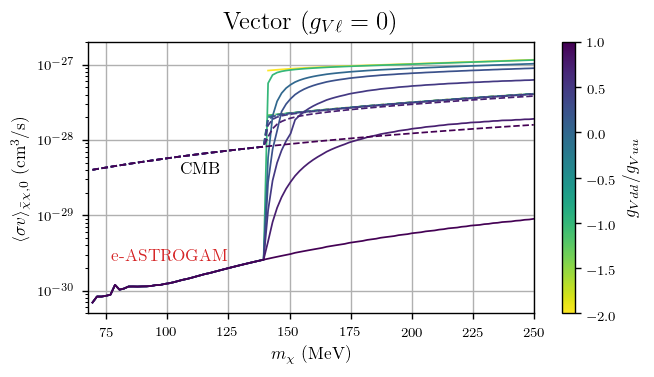

In [94]:
plt.figure(figsize=(latex_text_width_1col, 0.5*latex_text_width_1col))

for i, (ratio, lims, cmb) in enumerate(zip(ratios,
                                      vm_lims_e_astrogam_gvdd,
                                      vm_lims_cmb_gvdd)):
    plt.plot(vm_mxs, lims, color=m.to_rgba(ratio), linewidth=1)
    plt.plot(vm_mxs, cmb, '--', color=m.to_rgba(ratio), alpha=1, linewidth=1)

plt.text(105, 3.5e-29, "CMB", fontdict={"fontsize": 10})
plt.text(77, 2.5e-30, "e-ASTROGAM",
         fontdict={"fontsize": 10,
                   "color": plt.rcParams['axes.prop_cycle'].by_key()['color'][3]})

# Formatting
plt.xlim(vm_mxs[[0, -1]])
plt.ylim([5e-31, 2e-27])
plt.xscale("linear")
plt.yscale("log")
plt.grid()
plt.xlabel(r"$m_\chi$ (MeV)")
plt.ylabel(r"$\langle \sigma v \rangle_{\bar{\chi}\chi,0}$ (cm$^3$/s)")
plt.title(r"Vector ($g_{V\ell} = 0$)")
# plt.legend()

plt.gcf().colorbar(m, ax=plt.gca()).set_label(r"$g_{Vdd} / g_{Vuu}$")

plt.savefig("figures/vm_sigmav_limits_coupling_dependence.pdf")

## Limits when annihilating into $V V$

The result is not so interesting: the limit is the same as for $g_{Vuu} = g_{Vdd}$, but a factor of $\sim 1.5 - 2$ weaker since there are more photons but they have lower energy.

In [76]:
vm = VectorMediator(mx=1., mv=1000., gvxx=1., gvuu=1., gvdd=1., gvss=0., gvee=0., gvmumu=0.)

# Masses to scan over
mx_min, mx_max, n_mxs = 140, 280, 50
vm_mxs_no_med_ann = np.linspace(mx_min, mx_max, n_mxs)

vm.gvdd = vm.gvuu
vms_no_med_ann = vm.unbinned_limits(vm_mxs_no_med_ann, target_params=gc_target, bg_model=gc_bg_model, energy_res=lambda e: 0.01)

In [77]:
vm = VectorMediator(mx=1., mv=140., gvxx=1., gvuu=1., gvdd=0.1, gvss=0., gvee=0., gvmumu=0.)

# Masses to scan over
mx_min, mx_max, n_mxs = 140, 280, 50
vm_mxs_med_ann = np.linspace(mx_min, mx_max, n_mxs)

vm.gvdd = 0.75 * vm.gvuu
vms_med_ann = vm.unbinned_limits(vm_mxs_med_ann, target_params=gc_target, bg_model=gc_bg_model, energy_res=lambda e: 0.01)

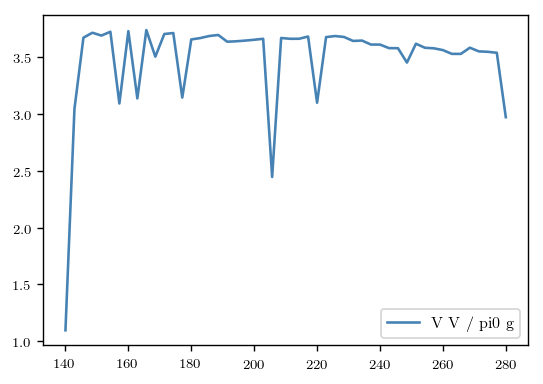

In [80]:
plt.plot(vm_mxs_no_med_ann, vms_med_ann / vms_no_med_ann, label="V V / pi0 g")

plt.legend()

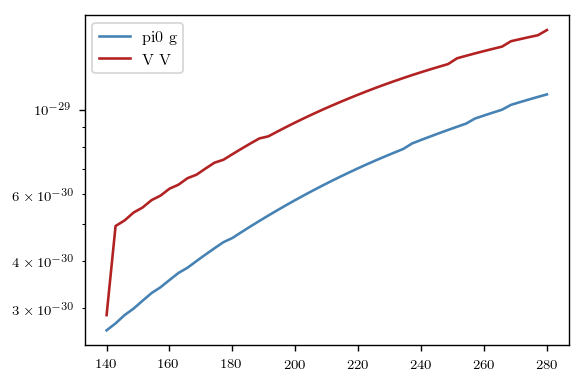

In [68]:
plt.plot(vm_mxs_no_med_ann, vms_no_med_ann, label="pi0 g")
plt.plot(vm_mxs_med_ann, vms_med_ann, label="V V")

plt.legend()
plt.yscale("log")

In [79]:
import os
os.system('say "Done computing limits"')

0

# Minimal examples of how to set limits
Any of the three blocks below can be run without needing to set anything else up.

Unbinned (ie, projected) limits:

In [9]:
import numpy as np
from hazma.scalar_mediator import ScalarMediator
from hazma.gamma_ray_parameters import (gc_target, gc_bg_model,
                                        A_eff_e_astrogam, energy_res_e_astrogam,
                                        T_obs_e_astrogam)

mxs = np.linspace(70., 250., 3)

sm = ScalarMediator(mx=1., ms=1000., gsxx=1., gsff=1., gsGG=1., gsFF=1.)

sm_lims_e_astrogam = sm.unbinned_limits(mxs, target_params=gc_target, bg_model=gc_bg_model,
                                        A_eff=A_eff_e_astrogam,
                                        energy_res=energy_res_e_astrogam,
                                        T_obs=T_obs_e_astrogam)

/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/theory/_theory_gamma_ray_limits.py:233: RuntimeWarning: invalid value encountered in sqrt
  df_de_a = 1./np.sqrt(I_B_val) * \
/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/theory/_theory_gamma_ray_limits.py:235: RuntimeWarning: invalid value encountered in sqrt
  df_de_b = -1./np.sqrt(I_B_val) * \
/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/theory/_theory_gamma_ray_limits.py:239: RuntimeWarning: invalid value encountered in sqrt
  return -I_S_val/np.sqrt(I_B_val), jac_val


Binned limits (ie, using current data from Fermi, COMPTEL or EGRET):

In [10]:
import numpy as np
from hazma.scalar_mediator import ScalarMediator
from hazma.gamma_ray_parameters import egret_diffuse

sm = ScalarMediator(mx=1., ms=1000., gsxx=1., gsff=1., gsGG=1., gsFF=1.)
mxs = np.linspace(70., 250., 3)

sm_lims_egret = sm.binned_limits(mxs, egret_diffuse)

Effective areas

Text(0,0.5,'$A_{\\mathrm{eff}}$ (cm$^2$)')

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


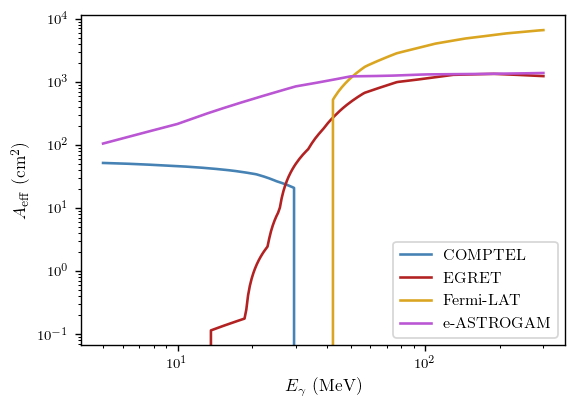

In [4]:
import numpy as np
from hazma.gamma_ray_parameters import (A_eff_comptel, A_eff_egret,
                                        A_eff_fermi, A_eff_e_astrogam)

e_gam_min, e_gam_max, n_e_gams = 5., 300., 250
e_gams = np.logspace(np.log10(e_gam_min), np.log10(e_gam_max), n_e_gams)

plt.plot(e_gams, A_eff_comptel(e_gams), label="COMPTEL")
plt.plot(e_gams, A_eff_egret(e_gams), label="EGRET")
plt.plot(e_gams, A_eff_fermi(e_gams), label="Fermi-LAT")
plt.plot(e_gams, A_eff_e_astrogam(e_gams), label="e-ASTROGAM")

plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$E_\gamma$ (MeV)")
plt.ylabel(r"$A_{\mathrm{eff}}$ (cm$^2$)")